<a href="https://colab.research.google.com/github/DongUk-Park/RnD/blob/main/GNN/Forecasting_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Preprocess

## Data Load

V : Historical Speed Record

W : Weighted Adjacency Matirx

In [4]:
import pandas as pd
# 알아보기 쉽도록 센서에 칼럼이름을 0~227로 붙여줌
speeds = pd.read_csv('/content/PeMSD7_V_228.csv', names=range(0,228))
distances = pd.read_csv('/content/PeMSD7_W_228.csv', names=range(0,228))

In [5]:
print(speeds)
print("#" * 40)
print(distances)

        0     1     2     3     4     5     6     7     8     9    ...   218  \
0      71.1  66.0  64.6  65.6  67.1  71.9  68.6  67.7  65.8  40.9  ...  69.1   
1      68.1  66.8  61.7  66.7  64.5  71.6  72.3  64.9  65.6  40.1  ...  70.6   
2      68.0  64.3  66.6  68.7  68.1  70.5  70.2  61.7  63.4  39.6  ...  72.2   
3      68.3  67.8  65.9  66.6  67.9  70.3  69.8  67.6  63.2  37.6  ...  71.2   
4      68.9  69.5  61.2  67.4  64.0  68.1  67.0  66.7  64.2  36.8  ...  71.3   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
12667  70.3  65.9  70.2  62.1  66.8  66.0  64.0  64.8  24.6  66.5  ...  66.0   
12668  69.9  54.0  68.2  62.2  67.4  65.8  64.4  61.3  35.1  69.2  ...  66.8   
12669  68.9  37.9  68.8  66.3  69.4  66.6  65.0  60.1  38.5  68.7  ...  66.4   
12670  69.2  37.8  68.7  63.6  68.5  66.2  64.1  60.9  40.5  68.5  ...  67.6   
12671  68.6  52.9  68.6  65.5  69.3  66.1  64.1  63.5  43.6  58.6  ...  66.6   

        219   220   221   222   223   2

데이터 시각화
228개 station들에 있는 센서들 시각화

Text(0, 0.5, 'Traffic speed')

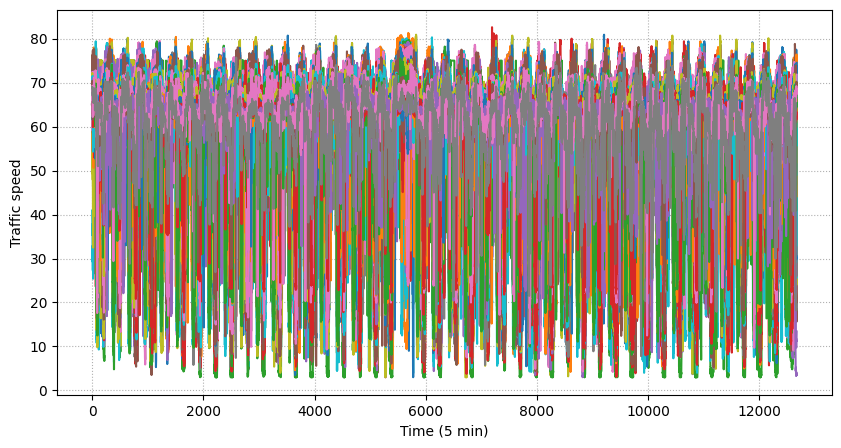

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(speeds)
plt.grid(linestyle=':')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

데이터가 너무 Noisy하다
그래서 평균, 표준편차로 확인

0        67.541228
1        67.479386
2        67.413158
3        67.305263
4        66.953070
           ...    
12667    64.194737
12668    64.602632
12669    64.779386
12670    64.787719
12671    64.992544
Length: 12672, dtype: float64 0         3.336814
1         3.364150
2         3.429710
3         3.313857
4         3.557463
           ...    
12667    10.124888
12668     9.644573
12669     9.621217
12670     9.335368
12671     8.948959
Length: 12672, dtype: float64


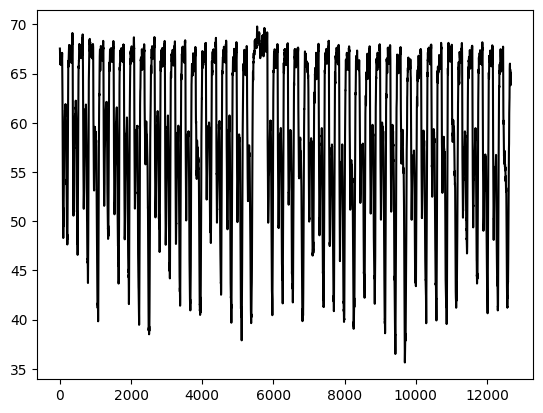

In [7]:
mean = speeds.mean(axis=1)
std = speeds.std(axis=1)
print(mean, std)

plt.plot(mean, 'k-') # k- : solid line (option)

Text(0, 0.5, 'Traffic speed')

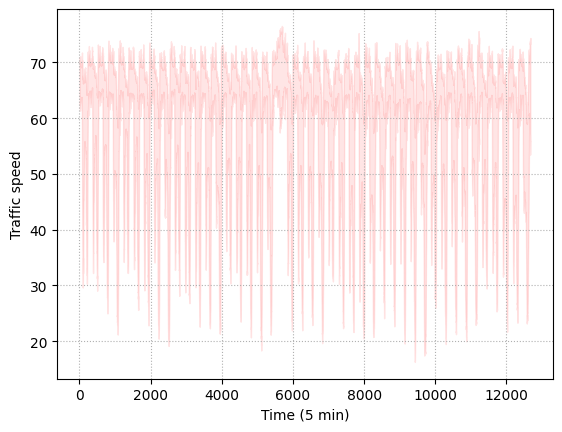

In [8]:
# 평균값 근처 표준편차를 색칠해줌, fill_between
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.grid(linestyle=':')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

Text(0, 0.5, 'Traffic speed')

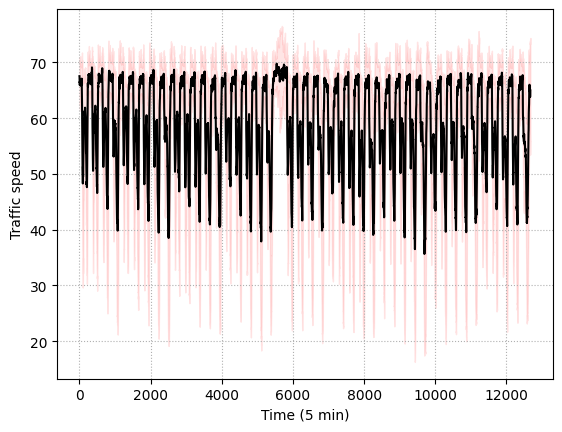

In [9]:
plt.plot(mean, 'k-') # k- : solid line (option)
# 평균값 근처 표준편차를 색칠해줌, fill_between
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.grid(linestyle=':')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

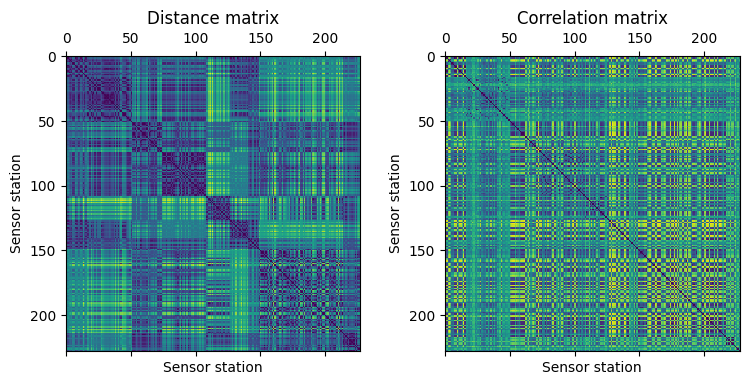

In [10]:
#create a figure with two horizontal subplots and some padding between them:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)

#plot the distance matrix:
ax1.matshow(distances)
ax1.set_xlabel("Sensor station")
ax1.set_ylabel("Sensor station")
ax1.title.set_text("Distance matrix")

# Pearson correlation coefficients for each sensor station
ax2.matshow(-np.corrcoef(speeds.T)) # if not transpose, we will get coreelation coefficients for time step
ax2.set_xlabel("Sensor station")
ax2.set_ylabel("Sensor station")
ax2.title.set_text("Correlation matrix")

##Processing the dataset

In [11]:
def compute_adj(distances, sigma2=0.1, epsilon=0.5):
    """
    각 센서 station을 노드로 보고, 엣지를 거리로 계산한 가중치로 봤을 때
    각 노드 사이를 엣지로 연결해주기 위해 각각의 station 사이의 거리로 가중치를 측정
    측정한 가중치가 0.5 이상 되는 station끼리만 엣지로 연결
    """
    d = distances.to_numpy() / 10000. # 왜 10000을 나눌까 ??
    d2 = d * d
    n = distances.shape[0]
    w_mask = np.ones([n, n]) - np.identity(n) # 대각행렬(본인과 본인 사이의 거리)만 0으로 바꾸어줌 -> i와 j와 다를 경우만 가중치를 계산
    return np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask # 가중치가 0.5 이상일때만 적용, 나머진 0

adj = compute_adj(distances) # 가중치가 0이 아닌 노드끼리만 연결함
adj[7]

array([0.61266012, 0.89792229, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.58120193, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Text(0, 0.5, 'Sensor station')

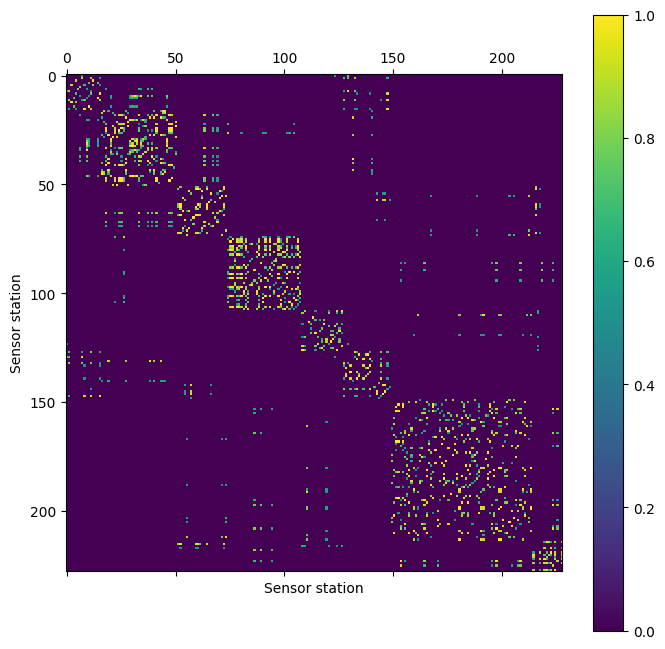

In [12]:
#위에서 계산한 가중치 인접행렬을 시각화
plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

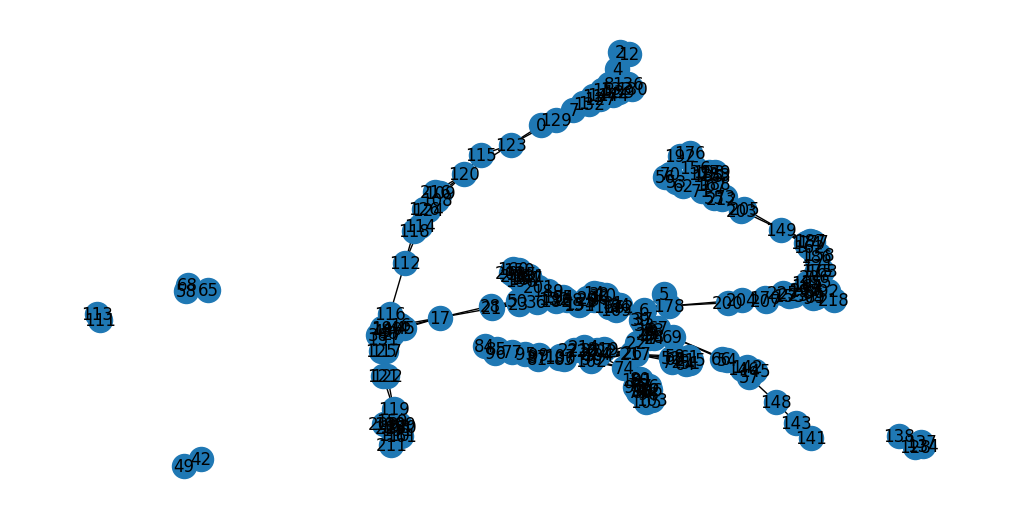

In [13]:
# networkx를 사용하여 그래프 모양으로 그려볼 수 있다

import networkx as nx
def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True)
    plt.show()

plot_graph(adj)

거리로 만든 가중치 그래프가 생성되었기 때문에 우린 이제  이 문제를 시계열 측면에서 어떻게 해결 할 지 생각하면 된다.

먼저 속도 값을 neural network에 넣을 수 있도록 값을 정규화해준다

정규화 이유 : 각 데이터의 특성이 다를 수 있는데(키,몸무게 등) 이를 모두 0-1 사이의 범위로 맞춰주어 동일한 측면에서 바라볼 수 있다. 이 외에도 수렴 속도 향상, 수치 안정성 등 장점이 있다

In [14]:
def zscore(x, mean, std): # 평균 = 0, 표준편차 = 1인 표준 정규 분포
    return (x - mean) / std

speeds_norm = zscore(speeds, speeds.mean(axis=0), speeds.std(axis=0))

print(speeds_norm.head(1))
print(speeds_norm.shape)

        0         1         2         3         4         5         6    \
0  0.950754  0.548255  0.502211  0.831672  0.793696  1.193806  0.983384   

        7         8         9    ...       218       219       220      221  \
0  0.737268  0.933144 -0.718118  ...  0.542628  1.011204  0.609678  0.79198   

        222       223       224      225       226       227  
0  0.709507  0.734163  0.569479  1.04614  0.712316  1.046962  

[1 rows x 228 columns]
(12672, 228)


In [15]:
lags = 24 # number of input data samples, 특정 시간(t) 이전 2시간동안의 traffic speed (input data 24개)
horizon = 48 # h, 4시간 동안의 속도 데이터 -> 5분에 1개, 1시간에 12개, 4시간에 48개
xs = [] # input matrix
ys = [] # ground truth matrix

for i in range(lags, speeds_norm.shape[0]-horizon): # 속도데이터 12672-h-lags 개에 대해서, (맨 처음 24개, 맨 끝 48개는 미포함)
    xs.append(speeds_norm.to_numpy()[i-lags:i].T) # 특정 시간 2시간 전까지의 샘플데이터(24개) 저장 , 0~23, 1~24, 2~25 ...
    ys.append(speeds_norm.to_numpy()[i+horizon-1]) # 특정 시간 4시간 이후의 속도 저장, 71, 72 73 ...

In [16]:
print(xs[0].shape, len(xs))
print(ys[0].shape)

(228, 24) 12600
(228,)


In [17]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split
# create the temporal graph using PyTorch Geometric Temporal.
# give edge index in COO format and edge weight

edge_index = (np.array(adj) > 0).nonzero() # 인접행렬에서 0보다 큰(엣지) 인덱스 저장
edge_weight = adj[adj > 0] # 인접행렬에서 0보다 큰(엣지) 가중치 값 추출

dataset = StaticGraphTemporalSignal(edge_index, edge_weight, xs, ys)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)


dataset[0]

/usr/local/lib/python3.10/dist-packages/torch_geometric_temporal/signal/static_graph_temporal_signal.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.LongTensor(self.edge_index)


Data(x=[228, 24], edge_index=[2, 1664], edge_attr=[1664], y=[228])

### Modules



```
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]


[docs]class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

```





```
class A3TGCN(torch.nn.Module):
    r"""An implementation of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        periods: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True
    ):
        super(A3TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.periods = periods
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self._setup_layers()

    def _setup_layers(self):
        self._base_tgcn = TGCN(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self._attention = torch.nn.Parameter(torch.empty(self.periods, device=device))
        torch.nn.init.uniform_(self._attention)

[docs]    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** (PyTorch Float Tensor): Node features for T time periods.
            * **edge_index** (PyTorch Long Tensor): Graph edge indices.
            * **edge_weight** (PyTorch Long Tensor, optional)*: Edge weight vector.
            * **H** (PyTorch Float Tensor, optional): Hidden state matrix for all nodes.

        Return types:
            * **H** (PyTorch Float Tensor): Hidden state matrix for all nodes.
        """
        H_accum = 0
        probs = torch.nn.functional.softmax(self._attention, dim=0)
        for period in range(self.periods):
            H_accum = H_accum + probs[period] * self._base_tgcn(
                X[:, :, period], edge_index, edge_weight, H
            )
        return H_accum
```



# Model
Implementing the A3T-GCN architecture(https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/recurrent/attentiontemporalgcn.html)

- A3T 그래프를 사용하면 복잡한 시간적,공간적 영향을 고려할 수 있음
- 공간적 의존성 :  한 위치의 교통 상황이 인근 위치의 교통 상황에 의해 영향을 받을 수 있다는 사실을 의미. 예를 들어, 교통 체증은 종종 인근 도로로 확산됨
- 시간적 의존성 : 특정 시점의 교통 상황이 이전 시간의 동일한 위치의 교통 상황에 의해 영향을 받을 수 있다는 사실을 의미. 예를 들어, 아침 피크 시간에 도로가 정체되면 저녁 피크 시간까지 정체가 지속될 가능성이 높다.


TGCN은 GCN과 GRU를 결합하여 각 입력 시계열에서 숨겨진 벡터를 생성한다. 이 두 레이어의 결합은 입력에서 공간적,시간적 정보를 캡처한다. 이후 Attention 모델을 사용하여 가중치를 계산, context vector를 출력한다. 최종 예측은 이 결과로 나온 context vector를 기반으로 한다.

In [ ]:
import torch
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    """
    hidden_dim : 32
    edge_attr : edge weight
    """
    def __init__(self, dim_in, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, out_channels=32, periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(lags, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
model.train()

for epoch in range(30):
    total_loss = 0
    count = 0
    for i, snapshot in enumerate(train_dataset):
        model.zero_grad()  # 이전 그래디언트를 지웁니다.
        y_pred = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()  # 그래디언트 계산
        optimizer.step()  # 최적화 단계: 가중치 업데이트
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1:>2} | Train MSE: {average_loss:.4f}")


# for epoch in range(30):
#     loss = 0
#     step = 0
#     for i, snapshot in enumerate(train_dataset):
#         y_pred = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
#         loss += torch.mean((y_pred-snapshot.y)**2)
#         step += 1
#     loss = loss / (step + 1)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1:>2} | Train MSE: {loss:.4f}")


Epoch  1 | Train MSE: 0.6502
Epoch 11 | Train MSE: 0.8356
Epoch 21 | Train MSE: 0.8785


평가 방법으로 Root Mean Squared Error(RMSE)와 Mean Absolute Error(MAE)등 고전 방법도 있고, 아래 두 가지의 시계열 데이터를 사용한 비교 방법 또한 사용한다.

Random Walk : 마지막 관찰을 예측 값으로 사용한다. 예시로 t 시점의 value는 t+h시점과 같다.

Historical Average : 전체 과거 평균을 사용한다

In [ ]:
def inverse_zscore(x, mean, std): # get back to the original values(before normalized)
    return x * std + mean

y_test = []
for snapshot in test_dataset:
    y_hat = snapshot.y.numpy()
    # test 데이터의 정답 속도를 계산 후 저장
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    y_test = np.append(y_test, y_hat)

gnn_pred = []
model.eval()
for snapshot in test_dataset:
    # test 데이터로 예측한 속도를 계산 후 저장
    y_hat = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    gnn_pred = np.append(gnn_pred, y_hat)


In [ ]:
def MAE(real, pred): # Mean Absolute Error
    return np.mean(np.abs(pred - real))
def RMSE(real, pred): # Root Mean Squared Error
    return np.sqrt(np.mean((pred - real) ** 2))
def MAPE(real, pred): # Mean Absolute Percentage Error
    return np.mean(np.abs(pred - real) / (real + 1e-5))

print(f'GNN MAE = {MAE(gnn_pred, y_test):.4f}')
print(f'GNN RMSE = {RMSE(gnn_pred, y_test):.4f}')
print(f'GNN MAPE = {MAPE(gnn_pred, y_test):.4f}')

In [ ]:
#Random walk
rw_pred = []
for snapshot in test_dataset:
    y_hat = snapshot.x[:,-1].squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    rw_pred = np.append(rw_pred, y_hat)

print(f'RW MAE  = {MAE(rw_pred, y_test):.4f}')
print(f'RW RMSE = {RMSE(rw_pred, y_test):.4f}')
print(f'RW MAPE = {MAPE(rw_pred, y_test):.4f}')

# Historical Average
ha_pred = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    y_hat = speeds_norm.to_numpy()[i-lags:i].T.mean(axis=1)
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    ha_pred.append(y_hat)
ha_pred = np.array(ha_pred).flatten()[-len(y_test):]

print(f'HA MAE  = {MAE(ha_pred, y_test):.4f}')
print(f'HA RMSE = {RMSE(ha_pred, y_test):.4f}')
print(f'HA MAPE = {MAPE(ha_pred, y_test):.4f}')

토폴로지 정보의 중요성을 측정하기 위해 이러한 측정항목을 LSTM 또는 GRU 네트워크에서 제공하는 예측과 비교하는 것은 흥미로울 것입니다.

In [ ]:
y_preds = [inverse_zscore(model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy(), speeds.mean(axis=0), speeds.std(axis=0)).mean() for snapshot in test_dataset]

mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5), dpi=300)
plt.plot(mean, 'k-', label='Mean')
plt.plot(range(len(speeds)-len(y_preds), len(speeds)), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.axvline(x=len(speeds)-len(y_preds), color='b', linestyle='--')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed to predict')
plt.legend(loc='upper right')